# MNIST Code Along with ANN

## Import

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
%matplotlib inline

## MNIST Dataset

In [23]:
transform = transforms.ToTensor()

In [24]:
train_data = datasets.MNIST(root="", train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [25]:
test_data = datasets.MNIST(root='', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

In [26]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [27]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


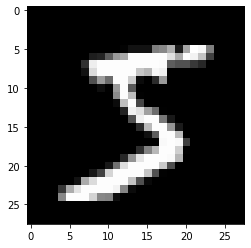

In [28]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray")

AxesImage(54,36;334.8x217.44)


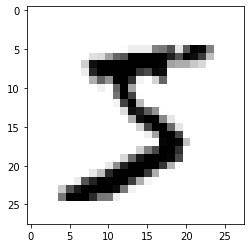

In [29]:
print(plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg"))

## Batch Loading

In [30]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=True)

In [31]:
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([100, 1, 28, 28])


Labels:  [   7    1    6    9    5    0    7    1    1    9    5    7]


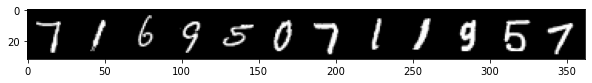

In [32]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the Model

In [33]:
class MultilayerPerceptron(nn.Module):

    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [34]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [35]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]

    for item in params:
        print(f"{item:>6}")
    print(f"__________\n{sum(params):>6}")

In [36]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
__________
105214


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
images.view(100,-1).size()

torch.Size([100, 784])

## Train the Model

In [41]:
epochs = 10
train_losses = []   
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):

    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr)

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.05966619  accuracy:  99.455%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.01519607  accuracy:  99.420%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.02385923  accuracy:  99.363%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.00618079  accuracy:  99.670%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.00314980  accuracy:  99.522%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.04220224  accuracy:  99.387%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.00174285  accuracy:  99.650%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.00882038  accuracy:  99.558%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.03560753  accuracy:  99.515%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.00622942  accuracy:  99.600%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.00530448  accuracy:  99.515%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.00083741  accuracy:  99.512%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.00298826  accuracy:  99.725%
epoch:  4  b

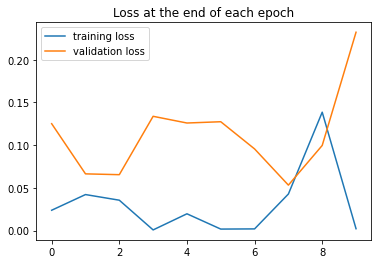

In [42]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

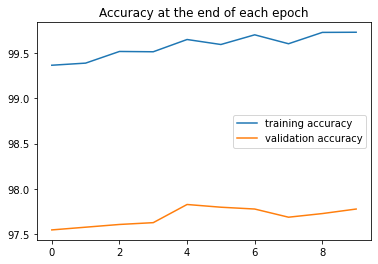

In [43]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluation of Test Data

In [44]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9755), tensor(9758), tensor(9761), tensor(9763), tensor(9783), tensor(9780), tensor(9778), tensor(9769), tensor(9773), tensor(9778)]

Test accuracy: 97.780%


In [45]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [46]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9778/10000 =  97.780%


## Confusion Matrix

In [47]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 967    0    1    0    1    2    4    1    5    0]
 [   1 1130    2    0    2    1    4    9    3    6]
 [   0    2 1011    3    3    0    1    8    3    0]
 [   1    0    3  988    1   11    1    0    2    4]
 [   3    0    1    0  967    3    7    4    8   16]
 [   2    0    0    4    0  863    4    1    2    5]
 [   1    0    0    0    3    1  935    0    2    0]
 [   1    1    3    4    0    1    0 1001    2    0]
 [   0    2   11    6    0    8    2    0  942    4]
 [   4    0    0    5    5    2    0    4    5  974]]


In [48]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

222

In [49]:
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [ 124  151  247  259  274  321  340  445  448  495  551  582]
Label: [   7    9    4    6    9    2    5    6    9    8    7    8]
Guess: [   4    8    2    0    3    7    3    0    8    2    1    2]


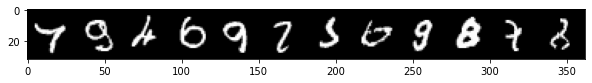

In [50]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));